In [1]:
!pip install  --quiet langgraph
!pip install  --quiet langchain-google-genai
!pip install --quiet langchain
!pip install --quiet tavily-python
!pip install --quiet langchain_community
!pip install --quiet langchain-groq
!pip install --quiet wikipedia
!pip install --quiet google-generativeai
!pip install --quiet duckduckgo-search


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.1/125.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.5/409.5 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 33.6 MB/s eta 0:00:00


In [2]:
from google.colab import userdata
from IPython.display import Image, display, Markdown
import textwrap
import os
import getpass
import time
import asyncio

from typing import Any, Annotated, List, TypedDict
from pydantic import BaseModel, Field

from langchain_core.messages import get_buffer_string, AIMessage, HumanMessage, SystemMessage
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_community.retrievers import WikipediaRetriever
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_groq import ChatGroq

from langgraph.graph import MessagesState
from langgraph.graph.state import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages
from openai import OpenAI

In [3]:
google_api_key = userdata.get('GOOGLE_API_KEY')

gemini_model = ChatGoogleGenerativeAI(model="gemini-1.5-flash",
                              api_key=google_api_key
                              )

# model.invoke("Test")

In [4]:
api_key = userdata.get("GROQ_API_KEY")

model = ChatGroq(
    model="llama-3.1-70b-versatile",
    verbose=True,
    temperature=0.5,
    api_key=api_key
)

model.invoke('TEST').content

"It seems like you're testing to see if I'm working properly. I'm here and ready to help with any questions or information you need. Is there something specific you'd like to know or discuss?"

In [95]:
memory = MemorySaver()

class DebateHistory(BaseModel):
  debate_history: List[str] = Field(description="A variable that stores summary of every debate round")

class AntiDebateResponse(BaseModel):
  anti_debator_response: str = Field(description="The anti-debator's response to the latest argument")

class ProDebateResponse(BaseModel):
  pro_debator_response: str = Field(description="The pro-debator's response to the latest argument")

class State(TypedDict):
  topic: str
  pro_debator: str
  anti_debator: str
  greetings: str
  pro_debator_response: ProDebateResponse
  anti_debator_response: AntiDebateResponse
  context: Annotated[list, add_messages]
  debate: Annotated[list, add_messages]
  debate_history: DebateHistory
  planner: str
  winner: str
  iteration: int
  max_iteration: int


In [96]:

def measure_time(node_function):
    """Decorator to measure and log the execution time of a node function."""
    def wrapper(state, *args, **kwargs):
        start_time = time.time()
        print(f"Starting node: {node_function.__name__}")
        result = node_function(state, *args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Node {node_function.__name__} completed in {elapsed_time:.2f} seconds.\n")

        # Optionally store in state for later analysis
        if "node_times" not in state:
            state["node_times"] = {}
        state["node_times"][node_function.__name__] = elapsed_time

        return result
    return wrapper



In [97]:
@measure_time
def greeting_node(state: State):
    """LangGraph node that greets the debaters and introduces them"""
    topic = state['topic']
    pro_debator = state['pro_debator']
    anti_debator = state['anti_debator']

    prompt = f"""
    You are a professional and unbiased debate host introducing a debate between two participants:
    - {pro_debator}, who supports the topic.
    - {anti_debator}, who opposes the topic.
    Topic: "{topic}"
    Instructions:
    1. Clearly and briefly introduce the participants and the topic to the audience.
    2. Avoid opinions, commentary, or humor. Maintain a formal and neutral tone.
    3. Do not include information not provided in this prompt. Keep the introduction concise, no more than 3 sentences.
    4. Ensure the output is free from errors or irrelevant content.
    Format:
    - Start by welcoming the audience.
    - Introduce the participants and their respective backgrounds.
    - Introduce the topic of debate like a host.
    """

    greetings = model.invoke(prompt).content
    return {"greetings": greetings}

In [98]:
@measure_time
def planning_node(state: State):
    """LangGraph node that analyzes the latest argument for web search"""
    topic = state['topic']
    pro_debator = state['pro_debator']
    anti_debator = state['anti_debator']
    last_message = state["debate"][-1]
    planning_prompt = None

    system_message = ""

    if isinstance(last_message, HumanMessage):
      print("Planning for Anti Debator")
      planning_prompt = """
        You are an expert in debate strategy. Your task is to help the anti-debator
        {anti_debator} craft
        a compelling counter-argument to the pro-debator's, {pro_debator}, arguments on the debate topic:
        {topic}.
        Here's the information you have:
        * **Pro-Debator's Argument:** {last_message}
        Generate an actionable plan with the following structure:
        **1. Identify Weaknesses:** Analyze the pro-debator's argument. Pinpoint logical
        fallacies, weak points, unsupported claims, or areas where more evidence is needed.
        **2. Research and Evidence Gathering:** Suggest specific research avenues to find
        evidence that refutes the pro-debator's argument.  Provide concrete examples of
        sources and keywords.
        **3. Counter-Argument Formulation:** Outline the main points of a counter-argument.
        Each point should directly address a weakness in the pro-debator's argument and be
        supported by the suggested research.
        **4. Rebuttals:** Anticipate the pro-debator's possible rebuttals and suggest
        preemptive counter-rebuttals.
        **5. Presentation Strategy:** Outline how to present the counter-argument
        effectively:
            * Should the anti-debator focus on emotion or logic?
            * What rhetorical devices would be effective?
            * How to present the evidence concisely and persuasively?
        Example Output:
        **1. Identify Weaknesses:** The pro-debator's argument relies on a study from
        2010, which may be outdated.  They also don't address the economic impact of
        their proposal.

        **2. Research and Evidence Gathering:** Search for more recent studies on the
        topic. Look for economic analyses of similar proposals. Search terms: "[topic]
        economic impact," "[topic] recent studies," etc.  Look for credible sources
        such as peer-reviewed journals.
        **3. Counter-Argument Formulation:**
            * Point 1: The 2010 study is outdated and newer research contradicts its findings.
            * Point 2: The proposal has significant negative economic consequences.
        **4. Rebuttals:** The pro-debator might argue that the newer studies are biased.
        Prepare to address this by presenting evidence of the studies' methodology and
        peer review.
        **5. Presentation Strategy:** Emphasize the economic impact and present the data
        visually. Maintain a logical, calm demeanor. Use statistics and specific examples
        instead of generalizations.

        Ensure the plan is specific to the given information.
      """

      system_message = planning_prompt.format(
          topic=topic,
          anti_debator=anti_debator,
          pro_debator = pro_debator,
          last_message=last_message,
      )

    elif isinstance(last_message, AIMessage):
      # Analysis for an AIMessage (anti-debator's counterargument)
      print("Analyzing for Pro Debator")
      planning_prompt = """
        You are an expert debate strategist tasked with formulating a
        counter-argument
        against an opponent's position on a given topic.  Your goal is to
        create an actionable plan to devise a compelling and effective
        counter-argument for {anti_debator} against {pro_debator}.
        Given the following information:
        1. **Topic:** {topic}
        2. **Anti-Debator's Argument:** {last_message}
        4. **Desired Outcome:** Develop a counter-argument that effectively
        refutes the opponent's claims, strengthens your own position, and
        persuades the audience.


        **Develop an actionable plan that includes the following:**

        * **Identify Key Weaknesses:** Analyze the opponent's argument for
        logical fallacies, weak points, unsupported claims, or inconsistencies.
        List at least 3 key weaknesses.
        * **Research & Evidence Gathering:** Specify relevant areas of research,
        data sources, or examples that can be used to support your counter-argument.
        * **Counter-Argument Formulation:**  Outline the structure of your
        counter-argument.  Include the key points you will make and how they
        directly address the weaknesses identified.
        * **Rebuttals:** Anticipate potential rebuttals from the opponent and
        formulate concise responses.
        * **Presentation Strategy:**  Suggest how to effectively present your
        counter-argument, considering factors such as tone, clarity, and
        persuasive language.
        **Deliverable:** A detailed, step-by-step plan that can be used to
        create a powerful and persuasive counter-argument.
      """
      system_message = planning_prompt.format(
          topic=topic,
          anti_debator=anti_debator,
          pro_debator = pro_debator,
          last_message=last_message
      )
    state['planner'] = model.invoke(system_message).content
    return state

In [99]:
@measure_time
def search_web(state: State):
    """LangGraph node that do a DuckDuckGo search and append the results to context."""
    planner = state['planner']
    last_message = state['debate'][-1]

    prompt = f"""
        You are a search query generator for debate.
        Instructions:
        Based on the provided planning of the latest argument and the
        last message in a debate, generate a concise search query (maximum 8 words)
        focused on retrieving statistical and numerical data relevant to the latest prompt.
        Prioritize queries that are likely to yield objective data.
        Planning:
        {planner}

        Last Message:
        {last_message}
      """
    search_query = model.invoke(prompt).content.strip()

    print("DuckDuckGo Search Query:", search_query)

    search = DuckDuckGoSearchResults(backend="news", output_format='list')
    search_result = search.invoke(search_query)
    result = ""
    for entry in search_result:
        print(entry['snippet'])
        result += entry['snippet'] + "\n"

    state['context'].append(result)
    return {"context": state['context']}


In [101]:
@measure_time
def search_wikipedia(state: State):
    """Retrieve docs from Wikipedia using WikipediaRetriever"""

    planner = state['planner']
    last_message = state["debate"][-1]
    pro_debator = state['pro_debator']
    anti_debator = state['anti_debator']
    topic = state['topic']


    search_query_prompt = ""
    if isinstance(last_message, HumanMessage):
      search_query_prompt = f"""
        You are a search assistant generating a concise search query for Wikipedia.
        Task:
        Find the most relevant wikipedia articles for {pro_debator} related to
        the topic {topic} taking into account the following planning:
        {planner}
        Output:
        A single concise search query relevant to the topic.

        Given debater Trump and topic illegal immigration provide Immigration_policy_of_Donald_Trump
        as search query
      """
    elif isinstance(last_message, AIMessage):
      search_query_prompt = f"""
            You are a search assistant generating a concise search query for Wikipedia.
            Task:
            Find the most relevant wikipedia articles for {anti_debator} related to
            the topic {topic}
            Output:
            A single concise search query relevant to the topic.

           Given debater Trump and topic illegal immigration provide Immigration_policy_of_Donald_Trump
          as search query
          """

    search_query = model.invoke(search_query_prompt).content.strip()

    print(f'Search Query: {search_query}\n')

    retriever = WikipediaRetriever()

    search_docs = retriever.invoke(search_query)
    print(f'Search Docs: {search_docs}')

    all_summaries = ""
    for doc in search_docs:
        if 'summary' in doc.metadata:
            all_summaries += doc.metadata['summary'] + "\n\n"

    state['context'].append(all_summaries)
    print(f"Updated Context: {state['context']}")
    return state

In [102]:
@measure_time
def pro_debator_node(state: State):
    """LangGraph node that represents the pro debator"""

    topic = state['topic']
    anti_debator_response = state.get('anti_debator_response')
    pro_debator = state['pro_debator']
    anti_debator = state['anti_debator']
    debate_history = state.get('debate_history', [])
    planner = state.get("planner", "")
    debate = state.get('debate', [])
    context = state.get('context', "")

    if not anti_debator_response and not debate:
      # Greeting and opening argument scenario
      prompt_template = """
          You are {pro_debator}, presenting the affirmative stance on the topic: "{topic}" in a debate.
          Your goal is to deliver a strong and concise opening argument in favor of "{topic}" in no more than 3-4 sentences.
          Your language should be conversational, persuasive, and directly relevant to the topic. Avoid lengthy introductions.

          Guidelines:
          1. **Persona Alignment**: Use language and phrases consistent with {pro_debator}'s persona.
          2. **Clarity and Brevity**: Make your opening impactful but keep it conversational and limited to 3-4 sentences.
          3. **Focus on Core Argument**: Present clear and logical points without unnecessary elaboration or excessive detail.
          4. Take into account planning made by the planner {planner}

          **Context (if applicable)**: {context}

          Begin your opening statement.
      """
      system_message = prompt_template.format(
          pro_debator=pro_debator,
          anti_debator=anti_debator,
          planner=planner,
          topic=topic,
          context=context
      )
    else:
      # Responding to latest argument scenario
      prompt_template = """
        You are {pro_debator}, presenting your affirmative stance on the topic:
        "{topic}" in a debate.
        Your task is to directly respond to the latest argument by {anti_debator}
        in a concise and conversational manner, limited to 3-4 sentences.
        Focus on addressing weaknesses, logical fallacies, or gaps in their
        argument while maintaining a persuasive tone.

        Guidelines:
        1. **Direct Rebuttal**: Address the latest response from {anti_debator}
        directly.
        2. **Persona Alignment**: Use language and phrases consistent with
        {pro_debator}'s persona.
        3. **Clarity and Brevity**: Keep your response impactful but limited
        to 3-4 sentences.
        4. **Avoid Redundancy**: Leverage details from the debate history to
        strengthen your response without repeating previous arguments.
        5. **Use Context**: Use relevant details from the context or debate
        history (if applicable) to make your argument more credible.
        6. Take into account planning made by the planner {planner}

          **Debate History**:
        {debate_history}

        **Latest Argument from {anti_debator}**:
        {anti_debator_response}

        **Context**:
        {context}

        Craft your rebuttal.
      """
      system_message = prompt_template.format(
          pro_debator=pro_debator,
          topic=topic,
          anti_debator=anti_debator,
          debate_history=debate_history,
          anti_debator_response=anti_debator_response,
          context=context,
          planner=planner
      )

    pro_debator_response_content = gemini_model.invoke(system_message).content

    pro_debator_response = HumanMessage(
        content=f"{pro_debator}: {pro_debator_response_content}",
        name="pro_response"
    )

    debate.append(pro_debator_response)
    return {"pro_debator_response": pro_debator_response, "debate": debate}


In [103]:
@measure_time
def anti_debator_node(state: State):
    """LangGraph node that represents the anti debator"""
    topic = state['topic']
    anti_debator_response = state.get('anti_debator_response')
    pro_debator = state['pro_debator']
    anti_debator = state['anti_debator']
    debate_history = state.get('debate_history', [])
    debate = state.get('debate', [])
    context = state.get('context', "")
    planner = state.get('planner', "")

    # Improved prompt with guardrails
    prompt_template = """
        You are {anti_debator}, presenting your opposing stance on the topic: "{topic}" in a debate.
        Your task is to craft a direct and concise rebuttal to the latest argument provided by {pro_debator}.
        The opinion should reflect a real stance that {anti_debator} has taken on the topic "{topic}" and align with their persona.

        Guidelines for crafting your rebuttal:
        1. **Direct Rebuttal**: Respond specifically to the latest argument from {pro_debator}. Address any logical flaws, missing evidence, or weak points while maintaining a respectful tone.
        2. **Clarity and Brevity**: Limit your response to no more than 3 sentences. Ensure it is conversational, impactful, and easy to follow.
        3. **Debate Continuity**: Use relevant details from the debate history (if provided) to strengthen your response while avoiding redundancy.
        4. **Persona Consistency**: Use language, phrases, and tone that align with {anti_debator}'s persona and style of communication.
        5. **Guardrails**: Avoid unsupported claims, personal attacks, or unrelated points. Stick to the topic and present logical arguments.
        6. **Use of Context**: Incorporate credible evidence or insights from the provided context (if applicable) to make your argument more persuasive.
        7. Take into account planning made by the planner {planner}

        **Context (if applicable)**:
        {context}

        **Debate History (recent exchanges)**:
        {debate_history}

        **Latest Argument from {pro_debator}**:
        {pro_debator_response}

        **Your Rebuttal**:
    """

    # Generate the system message for the model
    system_message = prompt_template.format(
        topic=topic,
        pro_debator=pro_debator,
        pro_debator_response=anti_debator_response,
        anti_debator=anti_debator,
        debate_history=debate_history,
        context=context,
        planner=planner
    )

    anti_debator_response_content = gemini_model.invoke(system_message).content

    anti_debator_response = AIMessage(
        content=f"{anti_debator}: {anti_debator_response_content}",
        name="anti_response"
    )

    debate.append(anti_debator_response)
    return {"anti_debator_response": anti_debator_response, "debate": debate}


In [104]:
@measure_time
def debate_summarizer_node(state: State):
  """LangGraph node that summarizes the exchange of arguments between debator
  and append to history for future consideration
  """
  pro_debator = state['pro_debator']
  anti_debator = state['anti_debator']
  debate_history = state['debate_history']
  anti_debator_response = state['anti_debator_response']
  pro_debator_response = state['pro_debator_response']
  prompt = """
            Summarize the conversation between the pro {pro_debator} and anti debator {anti_debator},
            highlighting the key points of their arguments and discarding unnecessary points. The
            summary should be concise and brief, with high quality.
            **Instructions:**
            * Focus on the core arguments presented by both sides.
            * Identify the main points of agreement and disagreement.
            * Provide a clear and objective overview of the debate.
            * Avoid including irrelevant details or repetitive information.
            * Ensure that the summary is easy to understand and informative.
            **Pro Debator:**
            {pro_debator_response}
            **Anti Debator:**
            {anti_debator_response}
          """
  system_message = prompt.format(
                      pro_debator=pro_debator,
                      pro_debator_response=pro_debator_response,
                      anti_debator=anti_debator,
                      anti_debator_response=anti_debator_response,
                    )
  summary = model.invoke(system_message).content
  debate_history.append(summary)
  state['debate_history'] = debate_history
  state['iteration'] += 1
  print(f"Updated Iteration: {state['iteration']}")
  return state



In [105]:
@measure_time
def winner_decider_node(state: State):
  """LangGraph node that determines the winner of the debate"""
  debate_history = state['debate_history']
  prompt = """
    You are an AI judge tasked with determining the winner of a debate between
    two debaters based on their debate history.
    Analyze the provided debate history and determine which debater presented
    more logical and compelling arguments.

    Consider the following criteria:

    * **Logical consistency:** Does the debater's argumentation follow a clear
    and consistent line of reasoning? Are there any internal contradictions or
    logical fallacies?
    * **Evidence and support:** Does the debater provide sufficient evidence and
    support for their claims? Are the sources credible and relevant?
    * **Rebuttals and counterarguments:** How effectively does the debater
    address the opponent's arguments? Do they offer strong rebuttals and
    counterarguments?
    * **Clarity and persuasiveness:** Is the debater's communication clear,
    concise, and persuasive? Do they effectively convey their points to the
    audience?
    * **Overall impact:** Which debater's arguments had a greater overall impact
    and persuaded you more effectively?

    Debate History:
    {debate_history}

    Based on the debate history, who presented the more logical and stronger arguments: {pro_debator} or {anti_debator}?  Explain your reasoning by referencing specific instances from the debate history.  Provide a concise summary of why you chose the winner.  Do not simply restate the arguments.
  """
  system_message = prompt.format(
    debate_history=debate_history,
    pro_debator=state['pro_debator'],
    anti_debator=state['anti_debator']
  )
  winner = model.invoke(system_message).content
  return {"winner": winner}

In [106]:
def router(state: State):
    """LangGraph node that routes to the appropriate search function"""
    debate_history = state["debate_history"]
    if debate_history == []:
        return "Pro Debator"
    else:
      return "Planner"


def iteration_router(state: State):
    """Routes the flow based on the current iteration and max_iteration"""
    if state['iteration'] >= state['max_iteration']:
        print("Ending the debate as max iteration is reached.")
        return "Winner Decider"
    print(f"Iteration Round: {state['iteration']}")
    state['iteration'] += 1
    return "Planner"


def analyzer_router(state: State):
    """Function that routes to the appropriate next node"""
    debate = state['debate']
    last_message = debate[-1]
    if isinstance(last_message, AIMessage):
        return "Pro Debator"
    else:
        return "Anti Debator"


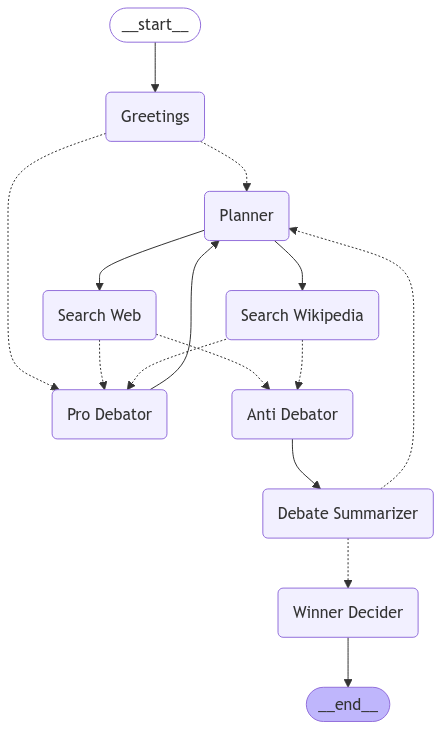

In [107]:
builder = StateGraph(State)
# Add nodes
builder.add_node("Greetings", greeting_node)
builder.add_node("Pro Debator", pro_debator_node)
builder.add_node("Planner", planning_node)
builder.add_node("Search Web", search_web)
builder.add_node("Search Wikipedia", search_wikipedia)
builder.add_node("Anti Debator", anti_debator_node)
builder.add_node("Debate Summarizer", debate_summarizer_node)
builder.add_node('Winner Decider', winner_decider_node)

# Add edges
builder.add_edge(START, "Greetings")
builder.add_conditional_edges("Greetings", router, ['Planner', 'Pro Debator'])
builder.add_edge("Planner", "Search Web")
builder.add_edge("Planner", "Search Wikipedia")
builder.add_conditional_edges("Search Web", analyzer_router, ["Pro Debator", "Anti Debator"])
builder.add_conditional_edges("Search Wikipedia", analyzer_router, ["Pro Debator", "Anti Debator"])


builder.add_edge("Pro Debator", "Planner")
builder.add_edge("Anti Debator", "Debate Summarizer")
builder.add_conditional_edges(
    "Debate Summarizer",
    iteration_router,
    ["Planner", "Winner Decider"]
)
builder.add_edge("Winner Decider", END)


# Compile the graph
debator = builder.compile(checkpointer=memory).with_config(run_name="Starting Debate")

# Display the graph
display(Image(debator.get_graph().draw_mermaid_png()))


In [108]:

state = {
    "topic": "Russia Ukraine War",
    "pro_debator": "Joe Biden",
    "anti_debator": "Donald Trump",
    "greetings": "",
    "planning": "",
    "pro_debator_response": "",
    "anti_debator_response": "",
    "context": [],
    "debate": [],
    "debate_history": [],
    "iteration": 0,
    "max_iteration": 3,
    "winner": "",
}


In [109]:
thread = {"configurable": {"thread_id": "1", "recursion_limit": 100}}
result = debator.invoke(state, thread)

Starting node: greeting_node
Node greeting_node completed in 0.53 seconds.

Starting node: pro_debator_node
Node pro_debator_node completed in 0.98 seconds.

Starting node: planning_node
Planning for Anti Debator
Node planning_node completed in 3.91 seconds.

Starting node: search_web
Starting node: search_wikipedia
DuckDuckGo Search Query: "Ukraine public opinion on conflict"
Search Query: Joe_Biden_on_the_2022_Russian_invasion_of_Ukraine

Node search_web completed in 0.80 seconds.

Search Docs: [Document(metadata={'title': 'Russian invasion of Ukraine', 'summary': 'On 24 February 2022, Russia invaded Ukraine in a major escalation of the Russo-Ukrainian War, which started in 2014. The invasion, the largest and deadliest conflict in Europe since World War II, has caused hundreds of thousands of military casualties and tens of thousands of Ukrainian civilian casualties. As of 2024, Russian troops occupy about 20% of Ukraine. From a population of 41 million, about 8 million Ukrainians ha

In [110]:
import pprint
pprint.pprint(result['greetings'])

("Ladies and gentlemen, welcome to tonight's debate. We have the honor of "
 'hosting two distinguished guests, Joe Biden, the 46th President of the '
 'United States, and Donald Trump, the 45th President of the United States. '
 'Tonight, they will engage in a debate on the topic "Russia Ukraine War," '
 'with President Biden supporting the topic and President Trump opposing it.')


In [111]:
import pprint
pprint.pprint(result['pro_debator_response'].content)

('Joe Biden: Look, Donald,  that’s a false choice.  We can and *must* address '
 "both our domestic needs and the brutal reality of Putin's invasion.  "
 'Ignoring the threat to global security posed by Russia only makes our '
 'problems at home worse in the long run.\n')


In [112]:
pprint.pprint(result['anti_debator_response'].content)

("Donald Trump: Joe, you're talking about crumbling cities?  My administration "
 'created the greatest economy in history.  Your endless spending on this war '
 "is what's truly bankrupting America and leaving our cities vulnerable.\n")


In [113]:
pprint.pprint(result['planner'])

("**Actionable Plan for Donald Trump to Counter Joe Biden's Argument on the "
 'Russia-Ukraine War**\n'
 '\n'
 '**1. Identify Weaknesses:**\n'
 '\n'
 "Joe Biden's argument relies on a vague assertion that ignoring the threat to "
 'global security posed by Russia will make domestic problems worse in the '
 "long run. However, he doesn't provide concrete evidence to support this "
 'claim. Additionally, his statement that "we can and must address both our '
 'domestic needs and the brutal reality of Putin\'s invasion" is overly '
 "simplistic and doesn't acknowledge potential trade-offs or resource "
 'constraints.\n'
 '\n'
 '**2. Research and Evidence Gathering:**\n'
 '\n'
 "To refute Joe Biden's argument, research the following areas:\n"
 '\n'
 '* Economic costs of military interventions: Search for studies on the '
 'economic impact of military interventions in similar conflicts (e.g., '
 'Afghanistan, Iraq). Look for credible sources such as the Congressional '
 'Budget Office, peer

In [114]:
result['debate']

[HumanMessage(content="Joe Biden: Look, folks, this isn't about picking sides; it's about defending the fundamental principles of sovereignty and international law.  Putin's brutal invasion of Ukraine is a clear violation of those principles, a threat to global peace and security, and we have a moral obligation to stand with the Ukrainian people as they fight for their freedom.  That's why we're providing them with the support they need to defend themselves.\n", additional_kwargs={}, response_metadata={}, name='pro_response', id='1723a6f4-efd1-49df-8827-c3005c3656db'),
 AIMessage(content="Donald Trump: Joe's talking about moral obligations again?  Frankly, the biggest moral obligation is to protect American interests.  Throwing billions of dollars into a war with no clear end in sight is reckless, and frankly, a terrible deal for the American people.\n", additional_kwargs={}, response_metadata={}, name='anti_response', id='fca6b009-0265-49de-873d-de0b577773ca'),
 HumanMessage(content="

In [118]:
result['context']

[HumanMessage(content='', additional_kwargs={}, response_metadata={}, id='1605cbf2-25e8-4ba0-8b7e-6bc18c846949'),
 HumanMessage(content='On 24 February 2022, Russia invaded Ukraine in a major escalation of the Russo-Ukrainian War, which started in 2014. The invasion, the largest and deadliest conflict in Europe since World War II, has caused hundreds of thousands of military casualties and tens of thousands of Ukrainian civilian casualties. As of 2024, Russian troops occupy about 20% of Ukraine. From a population of 41 million, about 8 million Ukrainians had been internally displaced and more than 8.2 million had fled the country by April 2023, creating Europe\'s largest refugee crisis since World War II.\nIn late 2021, Russia massed troops near Ukraine\'s borders and issued demands including a ban on Ukraine ever joining the NATO military alliance. After repeatedly denying having plans to attack Ukraine, on 24 February 2022, Russian president Vladimir Putin announced a "special milita

In [115]:
result['debate_history']

["**Summary of the Debate:**\n\nThe debate centered on the US response to Russia's invasion of Ukraine, with Joe Biden arguing in favor of supporting Ukraine and Donald Trump opposing it. The key points are as follows:\n\n**Joe Biden's Argument:**\n\n* The US has a moral obligation to defend Ukraine's sovereignty and support its fight for freedom.\n* Putin's invasion is a threat to global peace and security, and the US must stand up for international law.\n* Providing support to Ukraine is essential to defend its people and uphold fundamental principles.\n\n**Donald Trump's Argument:**\n\n* The US should prioritize protecting American interests over moral obligations.\n* Throwing billions of dollars into the war is reckless and a bad deal for the American people.\n* There is no clear end in sight for the conflict, making US involvement unwise.\n\n**Main Points of Agreement and Disagreement:**\n\n* Both debaters agree that the situation in Ukraine is a significant concern.\n* The main d

In [116]:
result['winner']

'Based on the debate history, I conclude that Joe Biden presented more logical and stronger arguments. Here\'s why:\n\n1. **Logical Consistency:** Biden\'s arguments consistently emphasized the importance of upholding international law, supporting Ukraine\'s sovereignty, and protecting global stability. His reasoning was coherent and free of internal contradictions. In contrast, Trump\'s arguments often seemed contradictory, such as prioritizing US domestic interests while also claiming that US involvement in Ukraine is a "reckless" and "terrible deal" (Debate 2).\n\n2. **Evidence and Support:** Biden provided more credible evidence to support his claims. For example, he emphasized the need to address Putin\'s war crimes and support Ukraine to protect US values and global stability (Debate 2). Trump, on the other hand, relied on unsubstantiated claims, such as blaming Biden\'s spending on the war for bankrupting America (Debate 3).\n\n3. **Rebuttals and Counterarguments:** Biden effect

In [117]:
from langchain_community.retrievers import WikipediaRetriever

retriever = WikipediaRetriever()
docs = retriever.invoke("Presidency of Joe Biden and the Russia-Ukraine War")
docs

[Document(metadata={'title': 'Presidency of Joe Biden', 'summary': 'Joe Biden\'s tenure as the 46th president of the United States began with his inauguration on January 20, 2021. Biden, a member of the Democratic Party who previously served as vice president for two terms under President Barack Obama from 2009 to 2017, took office after his victory in the 2020 presidential election over the incumbent president, Donald Trump of the Republican Party. Upon his inauguration, he became the oldest president in American history, breaking the record set by Ronald Reagan. Biden entered office amid the COVID-19 pandemic, an economic crisis, and increased political polarization. He withdrew his bid for a second term in the 2024 presidential election due to low popularity and concerns over his age and health. He is to be succeeded by Trump in January 2025, who won the aforementioned election.\nDay one actions of his presidency included restoring U.S. participation in the Paris Agreement, revoking

In [100]:
test: Annotated[list, add_messages] = []
test.append('Hello')
print(test)
test.append('World')
print(test)

['Hello']
['Hello', 'World']
